# Content Based Filtering - TMDB Dataset (1M Records)

## What I Learned in This Project 🎬💡

In this project, my focus was to learn how text vectorizers and cosine similarity works. Below is my approach to build a recommendation system. Note that this project is not focused on improving performance of the model  

1. **Textual Feature Engineering** 📝  
   - Learned to create a "metadata soup" by combining multiple textual features into a single string for each movie.
   - Explored the use of `CountVectorizer` to create a term-frequency matrix for the metadata soup

2. **Cosine Similarity for Recommendations** 🔍  
   - Understood the concept of cosine similarity and its application in content-based filtering to identify similar items based on textual data.
   - Practiced using `cosine_similarity` to calculate pairwise similarities across all movies, allowing for efficient retrieval of similar movies.

3. **Building a Recommendation Function** 🎯  
   - Learned to build a function that takes a movie title as input and retrieves the most similar movies by sorting similarity scores.

4. **Using Pandas for Index Mapping** 🗂️  
   - Discovered the importance of indexing by creating a dictionary that maps movie titles to DataFrame indices, enabling efficient lookups.



### Vectorizers I explored for the project

1. **Count Vectorizer**:
- Creates a sparse matrix
- Each row represents a document and every word is a column
- Count matrix = frequency of word in the document
- Computationally expensive due to high dimentionality
- Does not account for semantics


2. **TF-IDF(Term Frequency-Inverse Document Frequecy) Vectorizer**

- Creates sparse matrix and is computationally expensive

- Term Frequency (TF):
   - Represents the relative frequency of a word in a document.
   - No. of occurances of the term / Total no. of terms
  
- Inverse Document Frequency (IDF):
   - Measures how common or rare a word is across all documents.
   - log (Total no. of doc / No. of doc with that word)

   - The overall importance of each word in a document is the product of TF and IDF.



3. **Word2Vec**

- Takes account of textual semantics
- Embedding based approach
- Requires large datasets to learn meaningful embeddings
- Two models in Word2Vec - Skip Gram and CBOW
- Word level analysis

### Similarity Based Models

1. **Cosine Similarity**
- Calculates similarity based on the angle between the vectors in a n-dimentional space
- Values range from -1 (opposite) to 1 (identical), with 0 indicating orthogonal (no similarity).

2. Jaccard Similarity
- Measures similarity as the size of the intersection divided by the size of the union of two sets.
- Used for categorical data
- It's not vector based

3. Pearson Correlation
- Measures the linear correlation between two vectors.
- Frequently used in collaborative filtering for user and item similarity in rating-based recommendation systems.

4. Euclidean Distance
- Calculates the "straight-line" or absolute distance between two points in space.


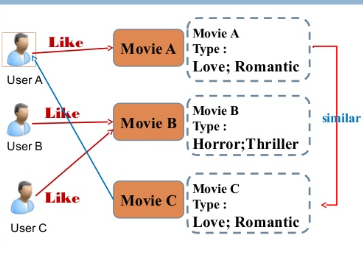

In [20]:
from IPython.display import Image
Image(filename='/content/content.png')

In [1]:
#Importing data from Kaggle
!kaggle datasets download alanvourch/tmdb-movies-daily-updates
!unzip tmdb-movies-daily-updates.zip

Dataset URL: https://www.kaggle.com/datasets/alanvourch/tmdb-movies-daily-updates
License(s): apache-2.0
 92% 229M/248M [00:01<00:00, 191MB/s]
100% 248M/248M [00:01<00:00, 153MB/s]
Archive:  tmdb-movies-daily-updates.zip
  inflating: TMDB_all_movies.csv     


In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# Load a subset of the dataset for processing efficiency
df = pd.read_csv("TMDB_all_movies.csv", nrows=100000)

# Selecting relevant columns for content-based filtering
columns_to_keep = [
    'id', 'title', 'original_language', 'overview', 'genres', 'cast',
    'director', 'director_of_photography', 'writers', 'producers',
    'music_composer', 'production_companies'
]
df_selected = df[columns_to_keep]

In [7]:
# The next step would be to convert the below instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.
features_to_clean = [
    'cast', 'director', 'genres', 'director_of_photography', 'writers',
    'producers', 'music_composer', 'production_companies'
]

def clean_text_data(text):
    """Converts text data to lowercase and removes spaces"""
    if isinstance(text, str):
        return [text.lower().replace(" ", "")]
    else:
        return []

for feature in features_to_clean:
    df_selected[feature] = df_selected[feature].apply(clean_text_data)


<ipython-input-7-72b1e7c91ba9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[feature] = df_selected[feature].apply(clean_text_data)


In [8]:
# Creating a "soup" feature from selected metadata fields for content similarity
soup_features = [
    'cast', 'director', 'genres', 'director_of_photography', 'writers',
    'producers', 'music_composer', 'overview', 'production_companies', 'original_language'
]

def create_metadata_soup(row):
    """Creates a concatenated string of relevant features for each movie."""
    soup = []
    for feature in soup_features:
        value = row.get(feature, '')
        if isinstance(value, list):
            soup.append(' '.join([str(item).replace(',', ' ') for item in value if item]))
        elif isinstance(value, str):
            soup.append(value.replace(',', ' '))
        else:
            soup.append('')
    return ' '.join(soup)

df_selected['metadata_soup'] = df_selected.apply(create_metadata_soup, axis=1)

<ipython-input-8-42e22168eb92>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['metadata_soup'] = df_selected.apply(create_metadata_soup, axis=1)


### Using Count Vectorizer

In [9]:
# Generating the count matrix for the metadata soup
count_vectorizer = CountVectorizer(stop_words='english')
count_matrix = count_vectorizer.fit_transform(df_selected['metadata_soup'])

# Computing cosine similarity matrix from the count matrix
cosine_sim_matrix = cosine_similarity(count_matrix, count_matrix)

In [10]:
# Mapping movie titles to index for quick lookup
indices = pd.Series(df_selected.index, index=df_selected['title']).to_dict()

def get_recommendations(title, cosine_sim=cosine_sim_matrix, df=df_selected):
    """Returns top 10 most similar movies to the provided movie title."""
    # Get the index of the given movie title
    idx = indices.get(title)
    if idx is None:
        return f"Movie '{title}' not found in the dataset."

    # Calculate similarity scores for all movies with respect to the given movie
    similarity_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies based on similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Exclude the first movie (itself) and select the top 10 similar movies
    top_similar_scores = similarity_scores[1:11]
    movie_indices = [i[0] for i in top_similar_scores]

    # Return titles of the most similar movies
    return df['title'].iloc[movie_indices]

### Getting some movie recommendations

In [11]:
get_recommendations('The Dark Knight')

,title
32943,The Dark Knight Rises
224,Batman Begins
28493,Doodlebug
6629,Following
96741,Interstellar
16347,Inception
41002,Belaja strela
846,The Prestige
25922,Batman: Under the Red Hood
18398,Batman Unmasked: The Psychology of The Dark Kn...


In [14]:
get_recommendations('The Avengers')

,title
68079,Avengers: Age of Ultron
1151,Iron Man
5310,Thor
5257,Iron Man 2
48018,Iron Man 3
68427,Captain America: The Winter Soldier
53704,Thor: The Dark World
53542,Marvel One-Shot: The Consultant
1335,Fantastic Four: Rise of the Silver Surfer
1164,Captain America: The First Avenger


In [17]:
get_recommendations('The Shawshank Redemption')

,title
386,The Green Mile
91156,Gladiator Days: Anatomy of a Prison Murder
34044,Lockdown
11386,Kill Kill Faster Faster
28829,Proximity
43629,The Woman in the Room
26352,The Boxer
26934,Girls in Prison
9328,Roy Jones Jr's Greatest Knockouts
3965,Decidme cómo es un árbol
